# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter_function=lambda variableId: 
                                                    variableId.getId().startswith('observable_') and not variableId.getId().endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': {'name': 'observable_x1', 'formula': 'x1'}, 'observable_x2': {'name': 'observable_x2', 'formula': 'x2'}, 'observable_x3': {'name': 'observable_x3', 'formula': 'x3'}, 'observable_x1_scaled': {'name': 'observable_x1_scaled', 'formula': 'scaling_x1 * x1'}, 'observable_x2_offsetted': {'name': 'observable_x2_offsetted', 'formula': 'offset_x2 + x2'}, 'observable_x1withsigma': {'name': 'observable_x1withsigma', 'formula': 'x1'}}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'ptr': <amici.amici.ReturnDataPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData > *' at 0x7f26d6a664e0> >, 't': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 

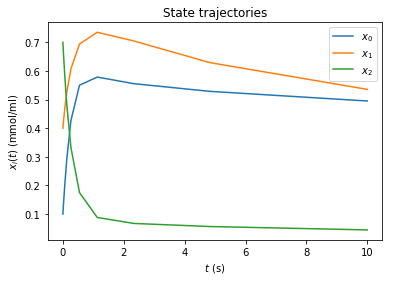

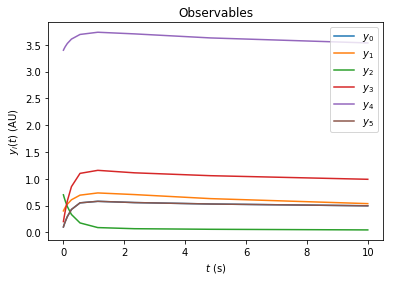

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
sigma_parameter = 0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters.copy()
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters:\t%s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters:\t%s' % default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    print()
    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
        print()
            
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    measurement = np.random.normal(loc=rdata['y'], scale=sigmay)
    print("\tSigma mean per observable:", sigmay.mean(axis=0))
    measurement[:, sigma_parameter_observable_idx] = np.random.normal(
        loc=rdata['y'][:, sigma_parameter_observable_idx], 
        scale=simulationParameters[sigma_parameter_idx])
    print("\tMean abs. relative measurement error per observable:")
    print("\t", np.mean(np.abs((measurement-rdata['y'])/rdata['y']), axis=0))

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    # return generated noisy measurents
    rdata['y'] = measurement
    return rdata

df, conditionDf = createData()

true_parameters:	[1.  0.5 0.4 2.  0.1 2.  3.  0.2 4. ]
Default parameters:	[1.  0.5 0.4 2.  0.1 2.  3.  0.2]

Condition 0: [1.]


TypeError: ExpData() missing 2 required positional arguments: 'sigma_y' and 'sigma_z'

In [ ]:
df

In [ ]:
conditionDf

In [ ]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

! /bin/bash -c "if [[ -f example_data.h5 ]]; then cp example_data.h5 example_data.h5.bak; fi"
# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0

hdf5FileMinibatch = 'example_data_minibatch.h5'
!cp {hdf5File} {hdf5FileMinibatch}

In [ ]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    for i in range(10):
        parameters = true_parameters_scaled
        parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters

!cp {hdf5File} {hdf5FileMinibatch}

In [ ]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 2
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


## Gradient check

In [ ]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


## Optimize

In [ ]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


In [ ]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

## Compare results

In [ ]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [ ]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

In [ ]:
!pwd

In [ ]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

In [ ]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

In [ ]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

In [ ]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [ ]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 1
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/max_iter 100
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_obj_change_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s retryOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


In [ ]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


In [ ]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemehierarchical/ example_data.h5


In [ ]:
filename = 'deletemehierarchical/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [ ]:
compareResults('deletemehierarchical/_rank00000.h5', -expectedLlh)

In [ ]:
list(model.getParameterNames())

In [ ]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deletemehierarchical/_rank00000.h5 / simh.h5 / --at-optimum

In [ ]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

In [ ]:
plotCorrelation(ymes, ysim)

In [ ]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [ ]:
!cp example_data.h5 example_data_ceres.h5
!../../../misc/optimizationOptions.py example_data_ceres.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemeceres/ example_data_ceres.h5


In [ ]:
compareResults('deletemeceres/_rank00000.h5', -expectedLlh)

## Minibatch optimization

In [ ]:
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s numStarts 1
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s retryOptimization 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s optimizer 10 # minibatch
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/maxEpochs 50
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/batchSize 2
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/Vanilla-learningRate 1e-5
!../../../misc/optimizationOptions.py {hdf5FileMinibatch}

In [ ]:
!../../../misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

In [ ]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

In [ ]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

### Compare learning rates

In [ ]:
learningRates = np.logspace(0, -5, 6)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !../../../misc/optimizationOptions.py {curInputFile} -s minibatch/Vanilla-learningRate learningRate
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/steadystate/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

In [ ]:
fig, axs = plt.subplots(nrows=len(learningRates + 1), figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)

In [ ]:
?plt.subplots_adjust

# TODO

## preeequilibration
## different optimizers
## improve timing

In [ ]:
list(model.getParameterNames())